In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from shapely.geometry import MultiPoint, mapping
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("./notebook/research/AllPoints_WGS84_final.csv")

In [4]:
model = KMeans(n_clusters=100, max_iter=1000, random_state=123)
label = model.fit_predict(df[["POINT_X", "POINT_Y"]])
centers = pd.read_excel("./notebook/research/modified_centers.xlsx", engine = "openpyxl").to_numpy()
df["cluster"] = label

In [5]:
cmap = plt.cm.get_cmap('hsv', 100)
colors = [mcolors.rgb2hex(cmap(i)) for i in range(100)]

seoul = folium.Map(location=[37.566734, 126.978123], zoom_start=7.5)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['POINT_Y'], row['POINT_X']],
        radius=3,
        color=colors[row['cluster']],
        fill=True,
        fill_opacity=0.7
    ).add_to(seoul)

for i, (Y, X) in enumerate(centers):
    folium.Marker(
        location=[X, Y],
         icon=folium.DivIcon(html=f"""
            <div style="
                font-size:20px;
                color:{colors[i]};
                font-weight:bold;
                line-height:40px;
            ">
                ★
            </div>
        """),
        popup=f'Center {i}'
    ).add_to(seoul)

for cluster_id in range(100):
    pts = df[df['cluster'] == cluster_id][['POINT_X','POINT_Y']].values
    if len(pts) >= 3:
        hull = MultiPoint(pts).convex_hull
        folium.GeoJson(
            mapping(hull),
            style_function=lambda feature, cid=cluster_id: {
                'fillColor': colors[cid],
                'color': colors[cid],
                'weight': 1,
                'fillOpacity': 0.1
            }
        ).add_to(seoul)

In [ ]:
seoul.save("result/seoul.html")

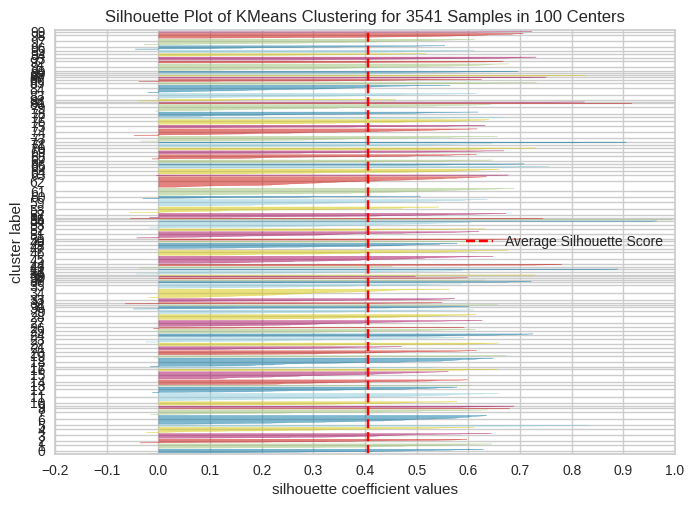

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3541 Samples in 100 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [9]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df[["POINT_X", "POINT_Y"]])
visualizer.show()

In [ ]:
df["silhouette"] = visualizer.silhouette_samples_
df.to_excel("result/result.xlsx", index=False)

df.groupby("cluster")["silhouette"].mean().sort_values(ascending=False).head(20)

,silhouette
cluster,
55,0.992502
54,0.958725
80,0.905188
72,0.864645
42,0.823483
88,0.784823
81,0.780734
5,0.728657
44,0.647439
